# A1 Data Curation
## Daniel White, DATA 512

### Overview
This Jupyter Notebook shows the code and intermediate outputs used to develop this chart (https://wiki.communitydata.cc/upload/4/48/En-wikipedia_traffic_200801-201709_thompson.png) displaying wikipedia page views over the last decade. The data behind the chart was collected using two different APIs associated with Wikipedia -- Legacy Pagecounts API and Pageviews API. The key difference being that Pagecounts included page views that came from Web crawlers which was phased out in May 2015.

### Data Acquisition

This section details the process of collecting data from the APIs and outputting the raw data to JSON files. First, a function and parameters were created to collect the data from the Legacy Pagecounts and Pageviews API.

In [1]:
#Import required packages
import json
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
endpoint_legacy = 'https://wikimedia.org/api/rest_v1/metrics/legacy/pagecounts/aggregate/{project}/{access-site}/{granularity}/{start}/{end}'
endpoint_pageviews = 'https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/{project}/{access}/{agent}/{granularity}/{start}/{end}'


params_legacy_d = {"project" : "en.wikipedia.org",
                 "access-site" : "desktop-site",
                 "granularity" : "monthly",
                 "start" : "2007120100",
                # for end use 1st day of month following final month of data
                 "end" : "2016080100"
                    }

# SAMPLE parameters for getting aggregated current standard pageview data
# see: https://wikimedia.org/api/rest_v1/#!/Pageviews_data/get_metrics_pageviews_aggregate_project_access_agent_granularity_start_end
params_pageviews_d = {"project" : "en.wikipedia.org",
                    "access" : "desktop",
                    "agent" : "user",
                    "granularity" : "monthly",
                    "start" : "2001010100",
                    # for end use 1st day of month following final month of data
                    "end" : '2018101000'
                        }

params_legacy_m = {"project" : "en.wikipedia.org",
                 "access-site" : "mobile-site",
                 "granularity" : "monthly",
                 "start" : "2007120100",
                # for end use 1st day of month following final month of data
                 "end" : "2016080100"
                    }

# see: https://wikimedia.org/api/rest_v1/#!/Pageviews_data/get_metrics_pageviews_aggregate_project_access_agent_granularity_start_end
params_pageviews_ma = {"project" : "en.wikipedia.org",
                    "access" : "mobile-app",
                    "agent" : "user",
                    "granularity" : "monthly",
                    "start" : "2001010100",
                    # for end use 1st day of month following final month of data
                    "end" : '2018101000'
                        }

params_pageviews_mw = {"project" : "en.wikipedia.org",
                    "access" : "mobile-web",
                    "agent" : "user",
                    "granularity" : "monthly",
                    "start" : "2001010100",
                    # for end use 1st day of month following final month of data
                    "end" : '2018101000'
                      }
headers = {
    'User-Agent': 'https://github.com/dwhite105',
    'From': 'dkwhite@uw.edu'
}
def api_call(endpoint,parameters):
    call = requests.get(endpoint.format(**parameters), headers=headers)
    response = call.json()
    return response

With the api_call function, five separate calls are made to the two APIs to collected all data related to desktop and mobile views. The raw data is then outputted into json files which are available in the respository.

In [3]:
legacy_d = api_call(endpoint_legacy, params_legacy_d)
legacy_m = api_call(endpoint_legacy, params_legacy_m)
pageviews_d = api_call(endpoint_pageviews, params_pageviews_d)
pageviews_ma = api_call(endpoint_pageviews, params_pageviews_ma)
pageviews_mw = api_call(endpoint_pageviews, params_pageviews_mw)

In [4]:
#Write API calls to json files
with open('pagecounts_desktop-site_200712-201608.json', 'w') as outfile1:
    json.dump(legacy_d, outfile1)
with open('pagecounts_mobile-site_200712-201608.json', 'w') as outfile:
    json.dump(legacy_m, outfile)
with open('pageviews_desktop_201507-201809.json', 'w') as outfile:
    json.dump(pageviews_d, outfile)
with open('pageviews_mobile-app_201507-201809.json', 'w') as outfile:
    json.dump(pageviews_ma, outfile)
with open('pageviews_mobile-web_201507-201809.json', 'w') as outfile:
    json.dump(pageviews_mw, outfile)

### Data Processing
This section covers the data processing steps taken to take the data from raw json files into a pandas dataframe. The output is then saved as a .csv file. First, two functions are created to parse the data from the pagecount and pageviews API outputs. The parser takes the timestamp and views count and outputs a pandas dataframe containing the year, month, and page views.

In [5]:
def pagecounts_json_parser(json_file):
    import json
    import pandas as pd
    pagecounts_year = []
    pagecounts_month = []
    pagecounts_count = []
    traffic = json_file['items'][0]['access-site']
    for i in range(0, len(json_file['items'])):
        pagecounts_year.append(json_file['items'][i]['timestamp'][:4])
        pagecounts_month.append(json_file['items'][i]['timestamp'][4:6])
        pagecounts_count.append(json_file['items'][i]['count'])
    pagecounts_df = pd.DataFrame(data = ({'year': pagecounts_year, 
                                        'month': pagecounts_month, 
                                        ('pc_count_' + traffic): pagecounts_count}))
    return pagecounts_df

In [6]:
def pageviews_json_parser(json_file):
    import json
    import pandas as pd
    pageviews_year = []
    pageviews_month = []
    pageviews_count = []
    traffic = json_file['items'][0]['access']
    for i in range(0, len(json_file['items'])):
        pageviews_year.append(json_file['items'][i]['timestamp'][:4])
        pageviews_month.append(json_file['items'][i]['timestamp'][4:6])
        pageviews_count.append(json_file['items'][i]['views'])
    pageviews_df = pd.DataFrame(data = ({'year': pageviews_year, 
                                        'month': pageviews_month, 
                                        ('pv_count_' + traffic): pageviews_count}))
    return pageviews_df

In [7]:
pagecounts_d_df = pagecounts_json_parser(legacy_d)
pagecounts_m_df = pagecounts_json_parser(legacy_m)
pageviews_d_df = pageviews_json_parser(pageviews_d)
pageviews_ma_df = pageviews_json_parser(pageviews_ma)
pageviews_mw_df = pageviews_json_parser(pageviews_mw)

A sample of the dataframe outputted from these functions is displayed below. Next, the dataframes are merged together on common year and month keys. 

In [9]:
pagecounts_d_df.head()

,month,pc_count_desktop-site,year
0,12,2998331524,2007
1,01,4930902570,2008
2,02,4818393763,2008
3,03,4955405809,2008
4,04,5159162183,2008


In [10]:
pagecounts_df = pd.merge(pagecounts_d_df, pagecounts_m_df, how='outer',on = ['month','year'])
pageviews_df = pd.merge(pd.merge(pageviews_d_df, pageviews_ma_df, how = 'outer', on = ['month', 'year']),
                        pageviews_mw_df, how = 'outer', on = ['month', 'year'])
df = pd.merge(pagecounts_df, pageviews_df, how = 'outer', on = ['month', 'year'])

In [11]:
df.head()

,month,pc_count_desktop-site,year,pc_count_mobile-site,pv_count_desktop,pv_count_mobile-app,pv_count_mobile-web
0,12,2.998332e+09,2007,NaN,NaN,NaN,NaN
1,01,4.930903e+09,2008,NaN,NaN,NaN,NaN
2,02,4.818394e+09,2008,NaN,NaN,NaN,NaN
3,03,4.955406e+09,2008,NaN,NaN,NaN,NaN
4,04,5.159162e+09,2008,NaN,NaN,NaN,NaN


Next, some quick data cleaning and processing steps are performed. This includes replacing all the NaN with zeroes, calculating new fields, changing column names, and filtering out unused columns. The resulting dataframe is shown below and is outputted to a .csv file.

In [12]:
df.fillna(0, inplace = True)
df['pageview_mobile_views'] = df['pv_count_mobile-app'] + df['pv_count_mobile-web']
df['pageview_all_views'] = df['pageview_mobile_views'] + df['pv_count_desktop']
df['pagecount_all_views'] = df['pc_count_desktop-site'] + df['pc_count_mobile-site']
df = df.rename(columns = {'pv_count_desktop': 'pageview_desktop_views', 
                          'pc_count_mobile-site' : 'pagecount_mobile_views',
                          'pc_count_desktop-site': 'pagecount_desktop_views'})

df = df[['year',
         'month',
         'pagecount_all_views', 
         'pagecount_desktop_views', 
         'pagecount_mobile_views',
         'pageview_all_views', 
         'pageview_desktop_views', 
         'pageview_mobile_views']]
df.head()

,year,month,pagecount_all_views,pagecount_desktop_views,pagecount_mobile_views,pageview_all_views,pageview_desktop_views,pageview_mobile_views
0,2007,12,2.998332e+09,2.998332e+09,0.0,0.0,0.0,0.0
1,2008,01,4.930903e+09,4.930903e+09,0.0,0.0,0.0,0.0
2,2008,02,4.818394e+09,4.818394e+09,0.0,0.0,0.0,0.0
3,2008,03,4.955406e+09,4.955406e+09,0.0,0.0,0.0,0.0
4,2008,04,5.159162e+09,5.159162e+09,0.0,0.0,0.0,0.0


In [13]:
df.to_csv('en-wikipedia_traffic_200712-201809.csv', index = False)

### Data Analysis
This section shows the steps to replicate the original chart. First, the date and month columns were converted into a datetime object to make a time series chart. The zeroes were replaced with NaNs to make for a cleaner looking chart where data did not exist. Six different columns containing views over time are then plotted on the chart. The chart axes and titles are meant to mimic the original chart. Some key differences in my version include the X and Y axes labels and the timeframe of analysis (data up to 09-2018 instead of 09-2017). The resulting figure is then outputted as a png file.

In [15]:
df['datetime'] =  pd.to_datetime(df['month'] + '-' + df['year'], format="%m-%Y")
df = df.replace(0, np.nan)
df.head()

,year,month,pagecount_all_views,pagecount_desktop_views,pagecount_mobile_views,pageview_all_views,pageview_desktop_views,pageview_mobile_views,datetime
0,2007,12,2.998332e+09,2.998332e+09,NaN,NaN,NaN,NaN,2007-12-01
1,2008,01,4.930903e+09,4.930903e+09,NaN,NaN,NaN,NaN,2008-01-01
2,2008,02,4.818394e+09,4.818394e+09,NaN,NaN,NaN,NaN,2008-02-01
3,2008,03,4.955406e+09,4.955406e+09,NaN,NaN,NaN,NaN,2008-03-01
4,2008,04,5.159162e+09,5.159162e+09,NaN,NaN,NaN,NaN,2008-04-01


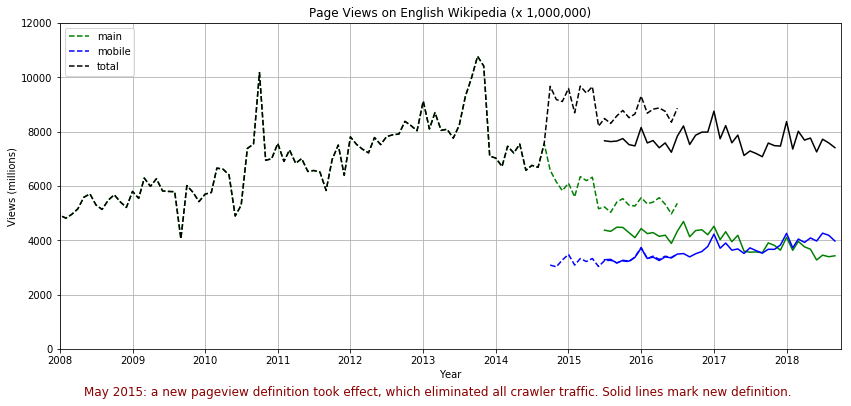

In [16]:
fig = plt.figure(figsize=(14,6))
ax1 = fig.add_subplot(111)
plt.plot(df['datetime'], df['pagecount_desktop_views']/1000000, color = 'green', linestyle = 'dashed')
plt.plot(df['datetime'], df['pagecount_mobile_views']/1000000, color = 'blue', linestyle = 'dashed')
plt.plot(df['datetime'], df['pagecount_all_views']/1000000, color = 'black', linestyle = 'dashed')
plt.plot(df['datetime'], df['pageview_desktop_views']/1000000, color = 'green', linestyle = 'solid')
plt.plot(df['datetime'], df['pageview_mobile_views']/1000000, color = 'blue', linestyle = 'solid')
plt.plot(df['datetime'], df['pageview_all_views']/1000000, color = 'black', linestyle = 'solid')
plt.title("Page Views on English Wikipedia (x 1,000,000)")
plt.legend(['main', 'mobile', 'total'], loc = 'upper left')
plt.xlabel("Year")
plt.ylabel("Views (millions)")
plt.xlim('2008-01-01','2018-10-01')
plt.ylim(0,12000)
plt.grid(True)
plt.suptitle("May 2015: a new pageview definition took effect, which eliminated all crawler traffic. Solid lines mark new definition.", 
             y = '0.01', va = 'bottom', color = 'darkred')
plt.savefig('en-wikipedia_traffic_200712-201809.png')
plt.show();

Observing the chart, you can see when Pagecounts began tracking desktop vs. mobile views towards the end of 2014. Also, the new Pageviews API had fewer views than Pagecounts during the period in which both were active. This can be accounted for by the elimination of views that came from Web crawlers during that time.